In [ ]:
import numpy as np
import pandas as pd
from scipy.linalg import hankel, eigh
from matplotlib import pyplot as plt
from matplotlib import style
import time

# SA1 Attacks

In [ ]:
#hankel([1,2,3,4], [0,7,7,8,9])

In [ ]:
#a = [[1,2],[3,4]]
#b = [[5,6], [7,8]]
#np.concatenate((a,b), axis = 1)

In [ ]:
xmeas = np.asarray(pd.read_csv('/content/drive/MyDrive/TE-DATASET/1SA1xmv9_hundred_data_1.csv', header=None))

In [ ]:
N,n = xmeas.shape
n

41

In [ ]:
# n: no of sensor
# N: no of time series measurement of each sensor
# x is N*n matrix, Where N is no of time series sample and n is no of sensors
# mu is a n*1 mean matrix
# sigma is a n*1 standard deviation matrix

# Normalize dataset to prevent some sensors from overweighing other sensors due to difference in scale.
def normalization(x,mu,sigma):
  for i in range(n):
    for j in range(N):
      x[j][i]= (x[j][i]-mu[i])//sigma[i]
  return x

In [ ]:
mu = np.mean(xmeas, axis=0)
#mu = mu[:,np.newaxis]
#mu.shape

sigma = np.std(xmeas, axis=0)
#sigma = sigma[:,np.newaxis]
#sigma[1]

xmeas = normalization(xmeas,mu,sigma)
xmeas.shape


(4801, 41)

In [ ]:
X_train_data = xmeas[:1500] # For training 
X_theta = xmeas[1000:3500] # For threshold calculation
X_test = xmeas[2700:] # For detection

In [ ]:
X_test.shape

(2101, 41)

In [ ]:
X_train_data.shape

(1500, 41)

# **Embedding (Creating Lag Covariance Matrix)**

In [ ]:
N = len(X_train_data)
L = 500
#print(L)
C = np.zeros([L,L], dtype = 'int')
#print(C.shape)
for i in range(n):
  if i==0:
    #print(i)
    X = X_train_data[:, i]
    h = hankel(X[:L],X[L-1:])
    C = np.matmul(h , h.T)
  else:
    #print(i)
    X = X_train_data[:, i]
    #print("\n X:",X)
    hn = hankel(X[:L],X[L-1:])
    C = C + np.matmul(hn , hn.T)
    hnk = np.concatenate((h,hn), axis=1)
    h = hn
print(C.shape, hnk.shape)

(500, 500) (500, 2002)


In [ ]:
eigenValues, eigenVectors = eigh(C)

In [ ]:
eigenValues.shape

(500,)

In [ ]:
eigenVectors.shape

(500, 500)

0.730004295436243


Text(0.5, 0, 'Cardinal Number of Eigen value ->')

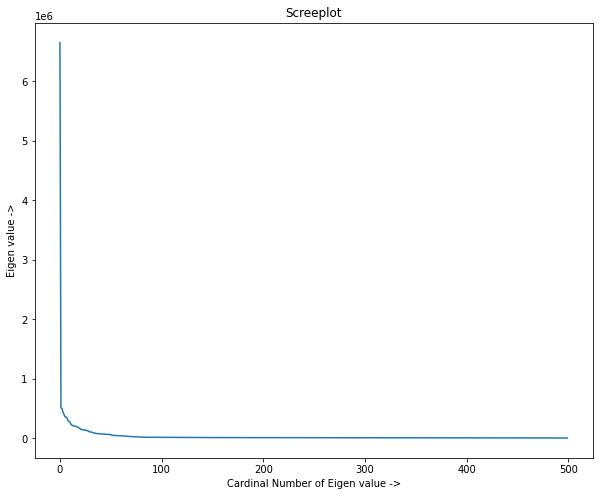

In [ ]:
idx = eigenValues.argsort()[::-1]
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]
# Sree plot
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.plot(eigenValues)
#print(eigenValues)
print(np.sum(eigenValues[0:55])/np.sum(eigenValues))
ax.set_title("Screeplot")
ax.set_ylabel("Eigen value ->")
ax.set_xlabel("Cardinal Number of Eigen value ->")

In [ ]:
# From the above scree plot, it is seen that the first eigen value is more 
# significant and the other eigen values are close to zero. Thus we choose r as 1
# and then we compute the U for projection and centroid in the signal subspace
r = 55
U = eigenVectors[:,:r] # r as statistical dimension
UT = U.T
UT.shape

(55, 500)

In [ ]:
Xtrg = np.linalg.norm(X_train_data, axis=1, ord=2)
Xtrg_lag = hankel(Xtrg[:L],Xtrg[L-1:])
Xtrg_lag.shape

(500, 1001)

In [ ]:
sub = np.matmul(UT, Xtrg_lag)
sub.shape

(55, 1001)

In [ ]:
c = np.mean(sub,axis=1)
c = c[:,np.newaxis]
c.shape

(55, 1)

In [ ]:
X_train_data
Xtrain = np.linalg.norm(X_train_data, axis=1, ord=2)
Xtrain_lag = hankel(Xtrain[:L],Xtrain[L-1:])
print(Xtrain_lag.shape)

sub_train = np.matmul(UT, Xtrain_lag)
dep_score_train = sub_train - c
#dep_score.shape
dt_scores_train = np.linalg.norm(dep_score_train, axis=0, ord=2)

(500, 1001)


In [ ]:
X_theta
Xval = np.linalg.norm(X_theta, axis=1, ord=2)
Xval_lag = hankel(Xval[:L],Xval[L-1:])
print(Xval_lag.shape)

sub_val = np.matmul(UT, Xval_lag)
dep_score = sub_val - c
#dep_score.shape
dt_scores = np.linalg.norm(dep_score, axis=0, ord=2)
#dt_scores.shape
dt_theta = np.max(dt_scores)*1.1
dt_theta

(500, 2001)


16.64634421777707

In [ ]:
X_test
start = time.time()
Xtest = np.linalg.norm(X_test, axis=1, ord=2)
Xtest_lag = hankel(Xtest[:L],Xtest[L-1:])
print(Xtest_lag.shape)

sub_test = np.matmul(UT, Xtest_lag)
dep_score_test = sub_test - c
#dep_score.shape
dt_scores_test = np.linalg.norm(dep_score_test, axis=0, ord=2)
end = time.time()
print("Time taken for testing is:",(end-start))
print(dt_scores.shape)
dt_theta_test = np.max(dt_scores_test)
dt_theta_test

(500, 1602)
Time taken for testing is: 0.012842178344726562
(2001,)


99.62675368872527

# **Visualizing the Departure Score**

1602 1602


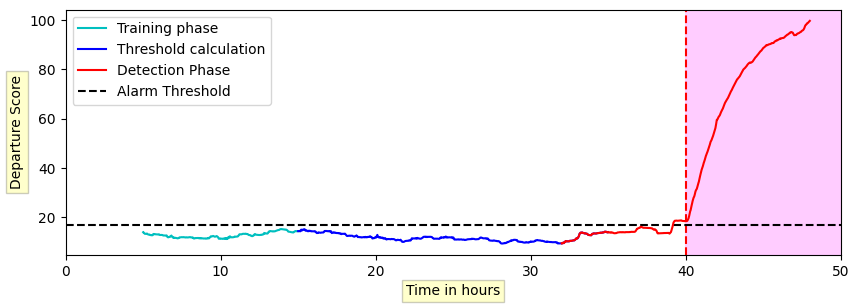

In [ ]:
#Testing Plots and Subplots
style.use('default')
box = dict(facecolor='yellow', pad=3, alpha=0.2)
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(211)

ax.set_xlim(0,5000)
# ax2.set_ylim(0,10)

xlables = list(range(0,5000,10)) # for both plots



# Plotting departure score
dy = dt_scores_train
dx = list(range(L,len(dy)+L))
ax.plot(dx, dy, 'c', label='Training phase')
dy = dt_scores
dx = list(range(1500,len(dy)+1500))
ax.plot(dx, dy, 'b', label='Threshold calculation')
dy = dt_scores_test
dx = list(range(3200,len(dy)+3200))
print(len(dx),len(dy))
ax.plot(dx, dy, 'r', label='Detection Phase')
ylim = list(ax.get_ylim())
ax.vlines(4000,ylim[0],ylim[1],linestyles='dashed', colors='r')
ax.set_xticklabels(xlables)
ax.hlines(dt_theta,0,5000,linestyles='dashed', label='Alarm Threshold')
ax.set_xlabel('Time in hours', bbox=box)
ax.set_ylabel('Departure Score', bbox=box)

X = np.array([[4000,5000],[4000,5000]])
Y = np.array([[ylim[0],ylim[0]],[ylim[1],ylim[1]]])
C = np.array([[4000,4500]])
ax.pcolormesh(X, Y, C, cmap='cool_r', alpha=0.2)
ax.legend(loc='upper left')
fig.align_ylabels([ax])

In [ ]:
sub_test.shape

(55, 1602)

In [ ]:
dt_scores_test.shape

(1602,)

In [ ]:
FP = 0
for i in range(0,800):
  if dt_scores_test[i] > dt_theta:
    FP += 1
print(FP)

TN = 0
for i in range(800,len(dt_scores_test)):
  if dt_scores_test[i] > dt_theta:
    TN+=1
TN

82


802

In [ ]:
TP = 800-FP 
FN = 802-TN
#print(TP,FP,TN,FN)
# Precision
prec = TP/(TP+FP)
rec = TP/(TP+FN)
acc = (TP+TN)/(TP+FP+TN+FN)
f1 = (2*prec*rec)/(prec+rec)
print("Precision:",prec, "\nRecall:", rec,"\nF1-Score:",f1, "\nAccuracy:", acc)

Precision: 0.8975 
Recall: 1.0 
F1-Score: 0.9459815546772068 
Accuracy: 0.9488139825218477
